# Detecting sound sources in YouTube videos

## First load all dependencies and set work and data paths

In [11]:
# set plotting parameters
%matplotlib inline
import matplotlib.pyplot as plt
# change notebook settings for wider screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# For embedding YouTube videos in Ipython Notebook
from IPython.display import YouTubeVideo
# and setting the time of the video in seconds
from datetime import timedelta

import numpy as np
import os
import sys
import urllib.request
import pandas as pd

sys.path.append(os.path.join('src', 'audioset_demos')) 

from __future__ import print_function

# signal processing library
from scipy import signal
from scipy.io import wavfile
import wave
import six
import tensorflow as tf
import h5py

# Audio IO and fast plotting
import pyaudio
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg

# Multiprocessing and threading
import multiprocessing


# Dependencies for creating deep VGGish embeddings
from src.audioset_demos import vggish_input
import vggish_input
import vggish_params
import vggish_postprocess
import vggish_slim
pca_params = 'vggish_pca_params.npz'
model_checkpoint = 'vggish_model.ckpt'

# Our YouTube video downloader based on youtube-dl module
from src.audioset_demos import download_youtube_wav as dl_yt

# third-party sounds processing and visualization library
import librosa
import librosa.display

# Set user
usr = 'maxvo'

MAXINT16 = np.iinfo(np.int16).max
print(MAXINT16)

FOCUS_CLASSES_ID = [0, 137, 62, 63, 500, 37] 
#FOCUS_CLASSES_ID = [0, 137, 37, 40, 62, 63, 203, 208, 359, 412, 500]
class_labels = pd.read_csv(os.path.join('src', 'audioset_demos', 'class_labels_indices.csv'))
CLASS_NAMES = class_labels.loc[:, 'display_name'].tolist()

FOCUS_CLASS_NAME_FRAME = class_labels.loc[FOCUS_CLASSES_ID, 'display_name']

FOCUS_CLASS_NAME = FOCUS_CLASS_NAME_FRAME.tolist()

print("Chosen classes for experiments:")
print(FOCUS_CLASS_NAME_FRAME)


# Set current working directory
src_dir = os.getcwd()

# Set raw wav-file data directories for placing downloaded audio
raw_dir = os.path.join(src_dir, 'data' ,'audioset_demos', 'raw')
short_raw_dir = os.path.join(src_dir, 'data', 'audioset_demos', 'short_raw')
if not os.path.exists(short_raw_dir):
    os.makedirs(short_raw_dir)
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)
    
audioset_data_path = os.path.join('data', 'audioset_demos', 'audioset', 'packed_features')

32767
Chosen classes for experiments:
0               Speech
137              Music
62     Finger snapping
63            Clapping
500            Silence
37             Humming
Name: display_name, dtype: object


## Download model parameters and PCA embedding

In [12]:
if not os.path.isfile(os.path.join('src', 'audioset_demos', 'vggish_model.ckpt')):
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/audioset/vggish_model.ckpt",
        filename=os.path.join('src', 'audioset_demos', 'vggish_model.ckpt')
    )

if not os.path.isfile(os.path.join('src', 'audioset_demos', 'vggish_pca_params.npz')):
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/audioset/vggish_pca_params.npz",
        filename=os.path.join('src', 'audioset_demos', 'vggish_pca_params.npz')
    )
    
if not os.path.isfile(os.path.join('data', 'audioset_demos', 'features.tar.gz')):
    urllib.request.urlretrieve(
        "https://storage.googleapis.com/eu_audioset/youtube_corpus/v1/features/features.tar.gz",
        filename=os.path.join('data', 'audioset_demos', 'features.tar.gz')
    )



In [13]:
import gzip
import shutil
with gzip.open(os.path.join('data', 'audioset_demos', 'features.tar.gz'), 'rb') as f_in:
    with open('packed_features', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [2]:
def save_data(hdf5_path, x, video_id_list, y=None):
    with h5py.File(hdf5_path, 'w') as hf:
        hf.create_dataset('x', data=x)
        hf.create_dataset('y', data=y)
        hf.create_dataset('video_id_list', data=video_id_list, dtype='S11')

def load_data(hdf5_path):
    with h5py.File(hdf5_path, 'r') as hf:
        x = hf['x'][:]
        if hf['y'] is not None:
            y = hf['y'][:]
        else:
            y = hf['y']
        video_id_list = hf['video_id_list'][:].tolist()

    return x, y, video_id_list

def time_str_to_sec(time_str='00:00:00'):
    time_str_list = time_str.split(':')
    seconds = int(
        timedelta(
            hours=int(time_str_list[0]),
            minutes=int(time_str_list[1]),
            seconds=int(time_str_list[2])
        ).total_seconds()
    )
    return seconds


class miniRecorder:
    
    def __init__(self, seconds=4, sampling_rate=16000):
        self.FORMAT = pyaudio.paInt16 #paFloat32  #paInt16
        self.CHANNELS = 1       # Must be Mono 
        self.RATE = sampling_rate       # sampling rate (Hz), 22050 was used for this application
        self.FRAMESIZE = 4200   # buffer size, number of data points to read at a time
        self.RECORD_SECONDS = seconds + 1 # how long should the recording (approx) be
        self.NOFRAMES = int((self.RATE * self.RECORD_SECONDS) / self.FRAMESIZE)  # number of frames needed
    
    def record(self):
        # instantiate pyaudio
        p = pyaudio.PyAudio()
        # open stream
        stream = p.open(format=self.FORMAT,
                       channels=self.CHANNELS,
                       rate=self.RATE,
                       input=True,
                       frames_per_buffer=self.FRAMESIZE)
        # discard the first part of the recording
        discard = stream.read(self.FRAMESIZE)
        print('Recording...')
        data = stream.read(self.NOFRAMES * self.FRAMESIZE)
        decoded = np.frombuffer(data, dtype=np.int16) #np.float32)
        print('Finished...')
        stream.stop_stream()
        stream.close()
        p.terminate()
        
        # Remove first second to avoid "click" sound from starting recording
        self.sound_clip = decoded[self.RATE:]

class Worker(QtCore.QRunnable):
    '''
    Worker thread

    Inherits from QRunnable to handler worker thread setup, signals and wrap-up.

    :param callback: The function callback to run on this worker thread. Supplied args and 
                     kwargs will be passed through to the runner.
    :type callback: function
    :param args: Arguments to pass to the callback function
    :param kwargs: Keywords to pass to the callback function

    '''

    def __init__(self, fn, *args, **kwargs):
        super(Worker, self).__init__()
        # Store constructor arguments (re-used for processing)
        self.fn = fn
        self.args = args
        self.kwargs = kwargs

    @QtCore.pyqtSlot()
    def run(self):
        '''
        Initialise the runner function with passed args, kwargs.
        '''
        self.fn(*self.args, **self.kwargs)

        
class AudioFile:
    def __init__(self, file, chunk):
        """ Init audio stream """
        self.chunk = chunk
        self.data = ''
        self.wf = wave.open(file, 'rb')
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(
            format = self.p.get_format_from_width(self.wf.getsampwidth()),
            channels = self.wf.getnchannels(),
            rate = self.wf.getframerate(),
            output = True
        )

    def play(self):
        """ Play entire file """
        self.data = self.wf.readframes(self.chunk)
        while self.data:
            self.stream.write(self.data)
            self.data = self.wf.readframes(self.chunk)
        self.close()

    def close(self):
        """ Graceful shutdown """ 
        self.stream.close()
        self.p.terminate()
    
    def read(self, chunk, exception_on_overflow=False):
        return self.data
        

        
class App(QtGui.QMainWindow):
    def __init__(self,
                 predictor,
                 n_top_classes=10,
                 plot_classes=FOCUS_CLASSES_ID,
                 parent=None):
        super(App, self).__init__(parent)
        
        ### Predictor model ###
        self.predictor = predictor
        self.n_classes = predictor.n_classes
        self.n_top_classes = n_top_classes
        self.plot_classes = plot_classes
        self.n_plot_classes = len(self.plot_classes)
        
        ### Start/stop control variable
        self.continue_recording = False
        self._timerId = None

        ### Settings ###
        self.rate = 16000    # sampling rate
        self.chunk = 1000    # reading chunk sizes, 
        #self.rate = 22050    # sampling rate
        #self.chunk = 2450    # reading chunk sizes, make it a divisor of sampling rate
        #self.rate = 44100    # sampling rate
        #self.chunk = 882    # reading chunk sizes, make it a divisor of sampling rate
        self.nperseg = 400   # samples pr segment for spectrogram, scipy default is 256
        # self.nperseg = 490   # samples pr segment for spectrogram, scipy default is 256
        self.noverlap = 0    # overlap between spectrogram windows, scipt default is nperseg // 8 
        self.tape_length = 20  # length of running tape
        self.plot_length = 10 * self.rate
        self.samples_passed = 0
        self.pred_length = 10
        self.pred_samples = self.rate * self.pred_length
        self.start_tape()    # initialize the tape
        self.eps = np.finfo(float).eps
        # Interval between predictions in number of samples
        self.pred_intv = (self.tape_length // 4) * self.rate
        self.pred_step = 10 * self.chunk
        self.full_tape = False
        #### Create Gui Elements ###########
        self.mainbox = QtGui.QWidget()
        self.setCentralWidget(self.mainbox)
        self.mainbox.setLayout(QtGui.QVBoxLayout())
        self.canvas = pg.GraphicsLayoutWidget()
        self.mainbox.layout().addWidget(self.canvas)
        self.label = QtGui.QLabel()
        self.mainbox.layout().addWidget(self.label)
        
        # Thread pool for prediction worker coordination
        self.threadpool = QtCore.QThreadPool()
        # self.threadpool_plot = QtCore.QThreadPool()
        print("Multithreading with maximum %d threads" % self.threadpool.maxThreadCount())
        
        # Play, record and predict button in toolbar
        '''
        self.playTimer = QtCore.QTimer()
        self.playTimer.setInterval(500)
        self.playTimer.timeout.connect(self.playTick)
        self.toolbar = self.addToolBar("Play")
        self.playScansAction = QtGui.QAction(QtGui.QIcon("control_play_blue.png"), "play scans", self)
        self.playScansAction.triggered.connect(self.playScansPressed)
        self.playScansAction.setCheckable(True)
        self.toolbar.addAction(self.playScansAction)
        '''
        
        # Buttons and user input
        btn_brow_1 = QtGui.QPushButton('Start/Stop Recording', self)
        btn_brow_1.setGeometry(300, 15, 250, 25)
        #btn_brow_4.clicked.connect(support.main(fname_points, self.fname_stl_indir, self.fname_stl_outdir))
        # Action: Start or stop recording
        btn_brow_1.clicked.connect(lambda: self.press_record())
        
        btn_brow_2 = QtGui.QPushButton('Predict', self)
        btn_brow_2.setGeometry(20, 15, 250, 25)
        # Action: predict on present tape roll
        btn_brow_2.clicked.connect(
            lambda: self.start_predictions(
                sound_clip=self.tape,
                full_tape=False
            )
        )
        
        self.le1 = QtGui.QLineEdit(self)
        self.le1.setGeometry(600, 15, 250, 21)
        self.yt_video_id = str(self.le1.text())
        
        self.statusBar().showMessage("Ready")

        # self.toolbar = self.addToolBar('Exit')
        # self.toolbar.addAction(exitAction)

        self.setGeometry(300, 300, 1400, 1200)
        self.setWindowTitle('Live Audio Event Detector')
        # self.show()
        
        #  line plot
        self.plot = self.canvas.addPlot()
        self.p1 = self.plot.plot(pen='r')
        self.plot.setXRange(0, self.plot_length)
        self.plot.setYRange(-0.5, 0.5)
        self.plot.hideAxis('left')
        self.plot.hideAxis('bottom')
        self.canvas.nextRow()
        
        # spectrogram
        self.view = self.canvas.addViewBox()
        self.view.setAspectLocked(False)
        self.view.setRange(QtCore.QRectF(0,0, self.spec.shape[1], 100))
        # image plot
        self.img = pg.ImageItem() #(border='w')
        self.view.addItem(self.img)
        
        # bipolar colormap
        pos = np.array([0., 1., 0.5, 0.25, 0.75])
        color = np.array([[0,255,255,255], [255,255,0,255], [0,0,0,255], (0, 0, 255, 255), (255, 0, 0, 255)], dtype=np.ubyte)
        cmap = pg.ColorMap(pos, color)
        lut = cmap.getLookupTable(0.0, 1.0, 256)
        self.img.setLookupTable(lut)
        self.img.setLevels([-15, -5])
        
        self.canvas.nextRow()
        
        # create bar chart
        #self.view2 = self.canvas.addViewBox()
        # dummy data
        #self.x = np.arange(self.n_top_classes)
        #self.y1 = np.linspace(0, self.n_classes, num=self.n_top_classes)
        #self.bg1 = pg.BarGraphItem(x=self.x, height=self.y1, width=0.6, brush='r')
        #self.view2.addItem(self.bg1)
        
        # Prediction line plot
        self.plot2 = self.canvas.addPlot()
        self.plot2.addLegend()
        self.plot_list = [None]*self.n_plot_classes
        for i in range(self.n_plot_classes):
            self.plot_list[i] = self.plot2.plot(
                pen=pg.intColor(i),
                name=CLASS_NAMES[self.plot_classes[i]]
            )
        
        self.plot2.setXRange(0, self.plot_length)
        self.plot2.setYRange(0.0, 1.0)
        self.plot2.hideAxis('left')
        self.plot2.hideAxis('bottom')

        # self.canvas.nextRow()
        #### Start  #####################
        
        # self.p = pyaudio.PyAudio()
        # self.start_stream()
        # self._update()

    def playScansPressed(self):
        if self.playScansAction.isChecked():
            self.playTimer.start()
        else:
            self.playTimer.stop()

    def playTick(self):
        self._update()

        
    def start_stream(self):
        if not self.yt_video_id:
            self.stream = self.p.open(
                format=pyaudio.paFloat32, 
                channels=1, 
                rate=self.rate,
                input=True,
                frames_per_buffer=self.chunk
            )
        else: 
            self.stream = AudioFile(self.yt_video_id, self.chunk)
            self.stream.play()

    
    def close_stream(self):
        self.stream.stop_stream()
        self.stream.close()
        self.p.terminate()
        # self.exit_pool()
        
    def read_stream(self):
        self.raw = self.stream.read(self.chunk, exception_on_overflow=False)
        data = np.frombuffer(self.raw, dtype=np.float32)
        return self.raw, data
    
    def start_tape(self):
        self.tape = np.zeros(self.tape_length * self.rate)
        # empty spectrogram tape
        self.f, self.t, self.Sxx = signal.spectrogram(
            self.tape[-self.plot_length:],
            self.rate, 
            nperseg=self.nperseg,
            noverlap=self.noverlap,
            detrend=False,
            return_onesided=True,
            mode='magnitude'
        )
        self.spec = np.zeros(self.Sxx.shape)
        self.pred = np.zeros((self.n_plot_classes, self.plot_length))
        
    def tape_add(self):
        if self.continue_recording:
            raw, audio = self.read_stream()
            self.tape[:-self.chunk] = self.tape[self.chunk:]
            self.tape[-self.chunk:] = audio
            self.samples_passed += self.chunk
        
        # spectrogram on whole tape
        # self.f, self.t, self.Sxx = signal.spectrogram(self.tape, self.rate)
        # self.spec = self.Sxx
        
        # spectrogram on last added part of tape
        self.f, self.t, self.Sxx = signal.spectrogram(self.tape[-self.chunk:], 
                                                      self.rate, 
                                                      nperseg=self.nperseg,
                                                      noverlap=self.noverlap)
        spec_chunk = self.Sxx.shape[1]
        self.spec[:, :-spec_chunk] = self.spec[:, spec_chunk:]
        # Extend spectrogram after converting to dB scale
        self.spec[:, -spec_chunk:] = np.log10(abs(self.Sxx) + self.eps)
        
        self.pred[:, :-self.chunk] = self.pred[:, self.chunk:]
        '''
        if (self.samples_passed % self.pred_intv) == 0:
            sound_clip = self.tape # (MAXINT16 * self.tape).astype('int16') / 32768.0
            if self.full_tape:
                # predictions on full tape
                pred_chunk = self.predictor.predict(
                    sound_clip=sound_clip[-self.pred_intv:],
                    sample_rate=self.rate
                )[0][self.plot_classes]
                self.pred[:, -self.pred_intv:] = np.asarray(
                        (self.pred_intv) * [pred_chunk]).transpose()

            else:
                # prediction, on some snip of the last part of the signal
                # 1 s seems to be the shortest time frame with reliable predictions
                self.start_predictions(sound_clip)
        '''
    
    def start_predictions(self, sound_clip=None, full_tape=False):
        #self.samples_passed_at_predict = self.samples_passed
        if sound_clip is None:
            sound_clip = self.tape
        
        if full_tape:
            worker = Worker(self.provide_prediction, *(), **{
                    "sound_clip": sound_clip,
                    "pred_start": -self.pred_samples,
                    "pred_stop": None,
                    "pred_step": self.pred_samples
                }
            )
            self.threadpool.start(worker)
        else:
            for chunk in range(0, self.pred_intv, self.pred_step):
                pred_start = - self.pred_intv - self.pred_samples + chunk
                pred_stop = - self.pred_intv + chunk
                worker = Worker(self.provide_prediction, *(), **{
                        "sound_clip": sound_clip,
                        "pred_start": pred_start,
                        "pred_stop": pred_stop,
                        "pred_step": self.pred_step
                    }
                )
                self.threadpool.start(worker)
    
    def provide_prediction(self, sound_clip, pred_start, pred_stop, pred_step):
        #samples_passed_since_predict = self.samples_passed - self.samples_passed_at_predict
        #pred_stop -= samples_passed_since_predict
        pred_chunk = self.predictor.predict(
            sound_clip=sound_clip[pred_start:pred_stop],
            sample_rate=self.rate
        )[0][self.plot_classes]
        #samples_passed_since_predict = self.samples_passed - self.samples_passed_at_predict - samples_passed_since_predict
        #pred_stop -= samples_passed_since_predict
        if pred_stop is not None:
            pred_stop_step = pred_stop - pred_step
        else:
            pred_stop_step = None
        self.pred[:, pred_stop_step:pred_stop] = np.asarray(
            (pred_step) * [pred_chunk]
        ).transpose()


    def exit_pool(self):
        """
        Exit all QRunnables and delete QThreadPool

        """

        # When trying to quit, the application takes a long time to stop
        self.threadpool.globalInstance().waitForDone()
        self.threadpool.deleteLater()

        sys.exit(0)
    
    def press_record(self):
        self.yt_video_id = str(self.le1.text())
        # Switch between continue recording or stopping it 
        # Start or avoid starting recording dependent on last press
        if self.continue_recording:
            self.continue_recording = False
            #if self._timerId is not None:
            #    self.killTimer(self._timerId)
            self.close_stream()
        else:
            self.continue_recording = True
            self.p = pyaudio.PyAudio()
            self.start_stream()
            self._update()
    
    def _update(self):
        try:
            if self.continue_recording:
                self.tape_add()

                # self.img.setImage(self.spec.T)
                #kwargs = {
                #    "image": self.spec.T,
                #    "autoLevels": False,
                #
                #worker = Worker(self.img.setImage, *(), **kwargs)
                #self.threadpool_plot.start(worker)

                self.img.setImage(self.spec.T, autoLevels=False)

                #worker = Worker(
                #    self.p1.setData,
                #    *(),
                #    **{'y': self.tape[-self.plot_length:]}
                #)
                #self.threadpool_plot.start(worker)

                self.p1.setData(self.tape[-self.plot_length:])

                #pred_var = np.var(self.pred, axis=-1)
                #pred_mean = np.mean(self.pred, axis=-1)

                #class_cand = np.where( (pred_mean > 0.001)*(pred_var > 0.01) )

                # n_classes_incl = min(self.n_top_classes, class_cand[0].shape[0]) 

                # print(n_classes_incl)

                for i in range(self.n_plot_classes):
                    #worker = Worker(
                    #    self.plot_list[i].setData,
                    #    *(),
                    #    **{'y': self.pred[i,:]}
                    #)
                    #self.threadpool_plot.start(worker)

                    self.plot_list[i].setData(self.pred[i,:]) # self.plot_classes[i],:])

                #self.bg1.setOpts(
                #    height=self.y1
                #)
                #self.bg1.setOpts(
                #    height=np.sort(
                #        self.pred[:, -1]
                #    )[-1:-(self.n_top_classes+1):-1]
                #)
                #print(np.max(self.tape), np.min(self.tape))
                # self.label.setText('Class: {0:0.3f}'.format(self.pred[-1]))

                QtCore.QTimer.singleShot(1, self._update)
            
        except KeyboardInterrupt:
            self.close_stream()

In [3]:
from AudioSetClassifier import AudioSetClassifier

    # model_type='decision_level_single_attention',
    # balance_type='balance_in_batch',
    # at_iteration=50000

#ASC = AudioSetClassifier(
#    model_type='decision_level_max_pooling', #single_attention',
#   balance_type='balance_in_batch',
#    iters=50000
#)

ASC = AudioSetClassifier()

Using TensorFlow backend.



Loading VGGish base model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)

In [ ]:
app=0           #This is the solution
app = QtGui.QApplication(sys.argv)
MainApp = App(predictor=ASC)
MainApp.show()
sys.exit(app.exec_())

In [8]:
minirec = miniRecorder(seconds=10, sampling_rate=16000)
minirec.record()

Recording...
Finished...


In [9]:
minirec_pred = ASC.predict(sound_clip=minirec.sound_clip / 32768.0, sample_rate=16000)

print(minirec_pred[:,[0, 37, 62, 63]])

[[  8.65663052e-01   1.39752665e-05   1.58889816e-04   1.18576922e-03]]


(1, 527)
                  display_name      prob
0                       Speech  0.865663
506         Inside, small room  0.050520
1    Male speech, man speaking  0.047573
5         Narration, monologue  0.047426
46                       Snort  0.043561
482                       Ping  0.025956
354                       Door  0.017503
458                      Arrow  0.016863
438                       Chop  0.014797
387                    Writing  0.014618


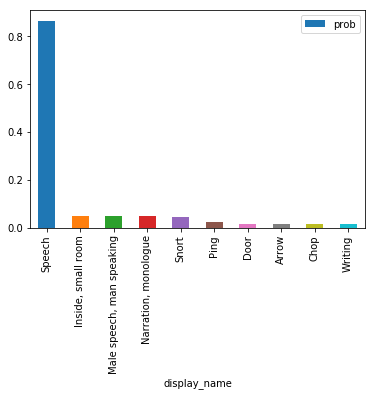

In [10]:
max_prob_classes = np.argsort(minirec_pred, axis=-1)[:, ::-1]
max_prob = np.sort(minirec_pred, axis=-1)[:,::-1]

print(max_prob.shape)

example = pd.DataFrame(class_labels['display_name'][max_prob_classes[0,:10]])
example.loc[:, 'prob'] = pd.Series(max_prob[0, :10], index=example.index)
print(example)
example.plot.bar(x='display_name', y='prob', rot=90)
plt.show()
print()
    

## Parameters for how to plot audio

In [32]:
# Sample rate
# this has to be at least twice of max frequency which we've entered
# but you can play around with different sample rates and see how this
# affects the results;
# since we generated this audio, the sample rate is the bitrate
sample_rate = vggish_params.SAMPLE_RATE

# size of audio FFT window relative to sample_rate
n_window = 1024
# overlap between adjacent FFT windows
n_overlap = 360
# number of mel frequency bands to generate
n_mels = 64

# max duration of short video clips
duration = 10

# note frequencies https://pages.mtu.edu/~suits/notefreqs.html
freq1 = 512.
freq2 = 1024.
# fmin and fmax for librosa filters in Hz - used for visualization purposes only
fmax = max(freq1, freq2)*8 + 1000. 
fmin = 0.

# stylistic change to the notebook
fontsize = 14

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['figure.titlesize'] = fontsize

## Choosing video IDs and start times before download

In [33]:
video_ids = [
    'BaW_jenozKc',
    'E6sS2d-NeTE',
    'xV0eTva6SKQ',
    '2Szah76TMgo',
    'g38kRk6YAA0',
    'OkkkPAE9KvE',
    'N1zUp9aPFG4'
]

video_start_time_str = [
    '00:00:00',
    '00:00:10',
    '00:00:05',
    '00:00:02',
    '00:03:10',
    '00:00:10',
    '00:00:06'
]
video_start_time = list(map(time_str_to_sec, video_start_time_str))

## Download, save and cut video audio

In [34]:
video_titles = []
maxv = np.iinfo(np.int16).max

for i, vid in enumerate(video_ids): 
    # Download and store video under data/raw/
    video_title = dl_yt.download_youtube_wav(
        video_id=vid,
        raw_dir=raw_dir,
        short_raw_dir=short_raw_dir,
        start_sec=video_start_time[i],
        duration=duration,
        sample_rate=sample_rate
    )
    video_titles += [video_title]
    
    print()
    '''
    audio_path = os.path.join(raw_dir, vid) + '.wav'
    short_audio_path = os.path.join(short_raw_dir, vid) + '.wav'
    
    # Load and downsample audio to 16000
    # audio is a 1D time series of the sound
    # can also use (audio, fs) = soundfile.read(audio_path)
    (audio, fs) = librosa.load(
        audio_path,
        sr = sample_rate,
        offset = video_start_time[i],
        duration = duration
    )
    
    # Store downsampled 10sec clip under data/short_raw/
    wavfile.write(
        filename=short_audio_path,
        rate=sample_rate,
        data=(audio * maxv).astype(np.int16)
    )
    '''

Done downloading, now converting ...
youtube-dl test video ''_ä↭𝕐 
	short clip saved in:
		 data/short_raw/BaW_jenozKc.wav
youtube-dl test video ''_ä↭𝕐 
	full clip saved in:
		 data/raw/BaW_jenozKc.wav

Done downloading, now converting ...
Brandweer - Prio 1 Binnenbrand De Grevelingen Grevelingen Den Bosch - 634TS 651AL 
	short clip saved in:
		 data/short_raw/E6sS2d-NeTE.wav
Brandweer - Prio 1 Binnenbrand De Grevelingen Grevelingen Den Bosch - 634TS 651AL 
	full clip saved in:
		 data/raw/E6sS2d-NeTE.wav

Done downloading, now converting ...
LED Lights + 100W Siren 
	short clip saved in:
		 data/short_raw/xV0eTva6SKQ.wav
LED Lights + 100W Siren 
	full clip saved in:
		 data/raw/xV0eTva6SKQ.wav

Done downloading, now converting ...
Start 
	short clip saved in:
		 data/short_raw/2Szah76TMgo.wav
Start 
	full clip saved in:
		 data/raw/2Szah76TMgo.wav

Done downloading, now converting ...
Splitting a Playing Card in ULTRA SLOW MOTION - Smarter Every Day 194 
	short clip saved in:
		 data/

In [ ]:
# Usage example for pyaudio
i = 6
a = AudioFile(
    os.path.join(short_raw_dir, video_ids[i]) + '.wav',
    chunk = 1000
)
a.play()
a.close()   

## Retrieve VGGish PCA embeddings 

In [35]:
video_vggish_emb = []

# Restore VGGish model trained on YouTube8M dataset
# Retrieve PCA-embeddings of bottleneck features
with tf.Graph().as_default(), tf.Session() as sess:
    # Define the model in inference mode, load the checkpoint, and
    # locate input and output tensors.
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, model_checkpoint)
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(
        vggish_params.OUTPUT_TENSOR_NAME)

    for i, vid in enumerate(video_ids): 
        audio_path = os.path.join(short_raw_dir, vid) + '.wav'

        examples_batch = vggish_input.wavfile_to_examples(audio_path)

        print(examples_batch.shape)

        # Prepare a postprocessor to munge the model embeddings.
        pproc = vggish_postprocess.Postprocessor(pca_params)

        # Run inference and postprocessing.
        [embedding_batch] = sess.run([embedding_tensor],
                                     feed_dict={features_tensor: examples_batch})
        print(embedding_batch.shape)
        postprocessed_batch = pproc.postprocess(embedding_batch)
        print(postprocessed_batch.shape)
        
        video_vggish_emb.extend([postprocessed_batch])

print(len(video_vggish_emb))

INFO:tensorflow:Restoring parameters from vggish_model.ckpt
(10, 96, 64)
(10, 128)
(10, 128)
(10, 96, 64)
(10, 128)
(10, 128)
(10, 96, 64)
(10, 128)
(10, 128)
(10, 96, 64)
(10, 128)
(10, 128)
(10, 96, 64)
(10, 128)
(10, 128)
(10, 96, 64)
(10, 128)
(10, 128)
(10, 96, 64)
(10, 128)
(10, 128)
7


## Plot audio, transformations and embeddings

### Function for visualising audio

In [14]:
def plot_audio(audio, emb):
    audio_sec = audio.shape[0]/sample_rate
    # Make a new figure
    plt.figure(figsize=(18, 16), dpi= 60, facecolor='w', edgecolor='k')
    plt.subplot(511)
    # Display the spectrogram on a mel scale
    librosa.display.waveplot(audio, int(sample_rate), max_sr = int(sample_rate))
    plt.title('Raw audio waveform @ %d Hz' % sample_rate, fontsize = fontsize) 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Define filters and windows
    melW =librosa.filters.mel(sr=sample_rate, n_fft=n_window, n_mels=n_mels, fmin=fmin, fmax=fmax)
    ham_win = np.hamming(n_window)
    
    # Compute fft to spectrogram
    [f, t, x] = signal.spectral.spectrogram(
        x=audio,
        window=ham_win,
        nperseg=n_window,
        noverlap=n_overlap,
        detrend=False,
        return_onesided=True,
        mode='magnitude')
        
    # Apply filters and log transformation
    x_filtered = np.dot(x.T, melW.T)
    x_logmel = np.log(x_filtered + 1e-8)
    x_logmel = x_logmel.astype(np.float32)

    # Display frequency power spectrogram
    plt.subplot(512)
    x_coords = np.linspace(0, audio_sec, x.shape[0])
    librosa.display.specshow(
        x.T,
        sr=sample_rate,
        x_axis='time',
        y_axis='hz',
        x_coords=x_coords
    )
    plt.xlabel("Time (s)")
    plt.title("FFT spectrogram (dB)", fontsize = fontsize)
    # optional colorbar plot
    plt.colorbar(format='%+02.0f dB')

    # Display log-mel freq. power spectrogram
    plt.subplot(513)
    x_coords = np.linspace(0, audio_sec, x_logmel.shape[0])
    librosa.display.specshow(
        x_logmel.T,
        sr=sample_rate,
        x_axis='time',
        y_axis='mel',
        x_coords=x_coords
    )
    plt.xlabel("Time (s)")
    plt.title("Mel power spectrogram used in DCASE 2017 (dB)", fontsize = fontsize)
    # optional colorbar plot
    plt.colorbar(format='%+02.0f dB')
    
    # Display embeddings
    plt.subplot(514)
    x_coords = np.linspace(0, audio_sec, emb.shape[0])
    librosa.display.specshow(
        emb.T,
        sr=sample_rate,
        x_axis='time',
        y_axis=None,
        x_coords=x_coords
    )
    plt.xlabel("Time (s)")
    plt.colorbar()
    
    plt.subplot(515)
    plt.scatter(
        x=emb[:, 0],
        y=emb[:, 1],
    )
    plt.xlabel("PC_1")
    plt.ylabel("PC_2")

    # Make the figure layout compact
    plt.tight_layout()
    
    plt.show()

### Visualise all clips of audio chosen

### Visualise one clip of audio and embed YouTube video for comparison

/usr/local/anaconda3/envs/audioset_tensorflow/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '
/usr/local/anaconda3/envs/audioset_tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


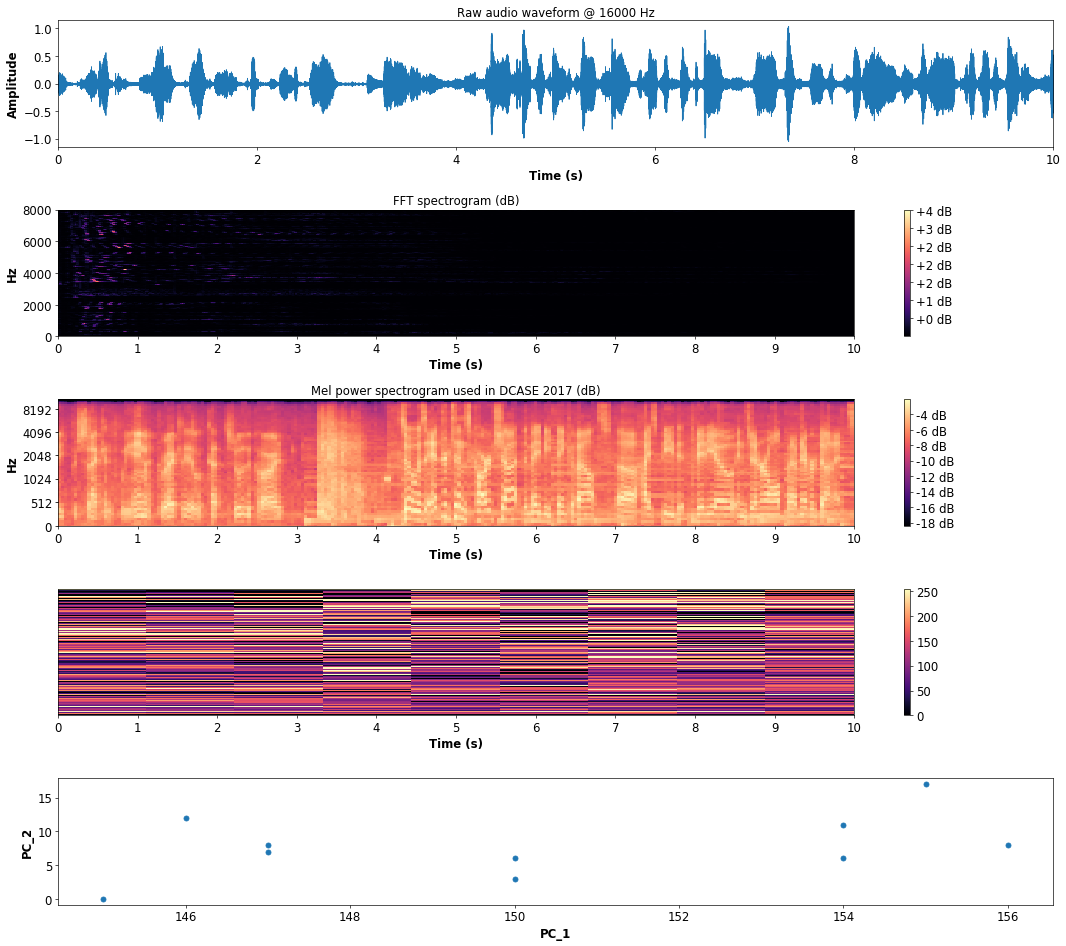

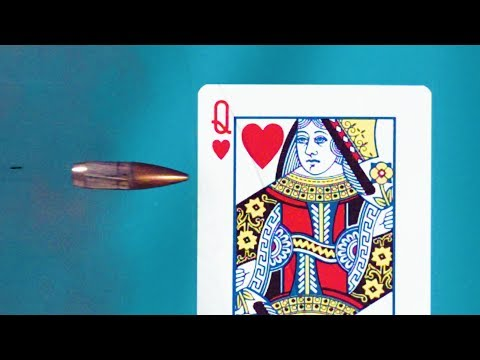

In [17]:
i = 4
vid = video_ids[i]

audio_path = os.path.join(raw_dir, vid) + '.wav'
    
# audio is a 1D time series of the sound
# can also use (audio, fs) = soundfile.read(audio_path)
(audio, fs) = librosa.load(
    audio_path,
    sr = sample_rate,
    offset = video_start_time[i],
    duration = duration
)

plot_audio(audio, video_vggish_emb[i])

start=int(
    timedelta(
        hours=0,
        minutes=0,
        seconds=video_start_time[i]
    ).total_seconds()
)

YouTubeVideo(
    vid,
    start=start,
    end=start+duration,
    autoplay=0,
    theme="light",
    color="red"
)

# Plot emb with scatter
# Check first couple of PCs, 
# for both train and test data, to see if the test is lacking variance

## Evaluate trained audio detection model

In [36]:
import audio_event_detection_model as AEDM
import utilities
from sklearn import metrics

model = AEDM.CRNN_audio_event_detector()



### Evaluating model on audio downloaded

In [38]:
(x_user_inp, y_user_inp) = utilities.transform_data(
    np.array(video_vggish_emb)
)
predictions = model.predict(
    x=x_user_inp
)

### Evaluating model on training data

In [37]:
(x_tr, y_tr, vid_tr) = load_data(os.path.join(audioset_data_path, 'bal_train.h5'))
(x_tr, y_tr) = utilities.transform_data(x_tr, y_tr)

pred_tr = model.predict(x=x_tr)



Loading top model with weights from:
models/md_50000_iters.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 10, 128)      0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 10, 1024)     132096      input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 10, 1024)     4096        dense_21[0][0]                   
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 10, 1024)     0           batch_normalization_13[0][0]     
_____________________________________________

In [21]:
print(pred_tr.max())

print(metrics.accuracy_score(y_tr, (pred_tr > 0.5).astype(np.float32)))

print(metrics.roc_auc_score(y_tr, pred_tr))
print(np.mean(metrics.roc_auc_score(y_tr, pred_tr, average=None)))

stats = utilities.calculate_stats(pred_tr, y_tr)
mAUC = np.mean([stat['auc'] for stat in stats])



0.999973
0.130054151625
0.984930222934
0.984930222934


In [39]:
max_prob_classes = np.argsort(predictions, axis=-1)[:, ::-1]
max_prob = np.sort(predictions, axis=-1)[:,::-1]

In [40]:
print(mAUC)

print(max_prob.max())

print(max_prob[:,:10])

print(predictions.shape)

print(max_prob_classes[:,:10])

0.984930222934
0.87231
[[ 0.85056537  0.84223366  0.27688268  0.23452662  0.12581593  0.05143182
   0.02919197  0.02805768  0.02699612  0.01704121]
 [ 0.32978365  0.1321748   0.10872712  0.10825769  0.07952435  0.07356845
   0.04511245  0.03998784  0.03936461  0.03507403]
 [ 0.87230974  0.86156976  0.81838012  0.65405416  0.33036518  0.19758119
   0.15447959  0.08347502  0.06029229  0.05457394]
 [ 0.18422596  0.1432181   0.11541138  0.10077612  0.06737918  0.06132444
   0.05907288  0.05696394  0.04590562  0.03907897]
 [ 0.73532987  0.50799     0.30799454  0.16915816  0.08796553  0.07880456
   0.06258963  0.06124302  0.0446381   0.04250672]
 [ 0.76051241  0.3201108   0.24144822  0.24041927  0.21041867  0.16869307
   0.16662784  0.10298688  0.09610511  0.08055314]
 [ 0.67560714  0.18969995  0.17008433  0.08974643  0.07025716  0.06953395
   0.0580983   0.05612611  0.05410512  0.04845256]]
(7, 527)
[[  7   0   5 518 525   1 137 407 506   4]
 [137 396  35 322   0 398 325 318 300 308]
 [322 

In [41]:
from numpy import genfromtxt
import pandas as pd

class_labels = pd.read_csv('class_labels_indices.csv')

In [42]:
print(class_labels['display_name'][max_prob_classes[5,:10]])

0                                       Speech
514                        Environmental noise
72                                      Animal
112    Bird vocalization, bird call, bird song
111                                       Bird
113                               Chirp, tweet
127                                    Cricket
510                  Outside, rural or natural
126                                     Insect
98                                        Fowl
Name: display_name, dtype: object


In [ ]:
for i, vid in enumerate(video_ids[0]):
    print(video_titles[i])
    print()
    
    example = pd.DataFrame(class_labels['display_name'][max_prob_classes[i,:10]])
    example.loc[:, 'prob'] = pd.Series(max_prob[i, :10], index=example.index)
    print(example)
    example.plot.bar(x='display_name', y='prob', rot=90)
    plt.show()
    print()

## Investigating model predictions on downloaded audio clips

youtube-dl test video ''_ä↭𝕐



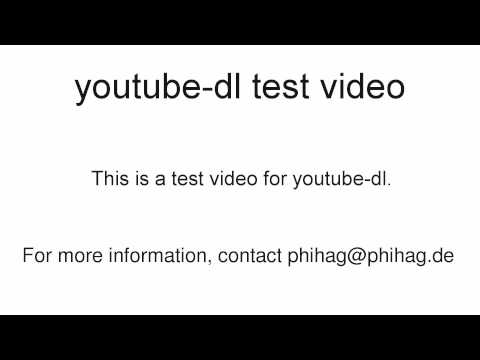

In [46]:
i = 0
vid = video_ids[i]

print(video_titles[i])
print()

YouTubeVideo(
    vid,
    start=start,
    end=start+duration,
    autoplay=0,
    theme="light",
    color="red"
)

                  display_name      prob
7           Speech synthesizer  0.850565
0                       Speech  0.842234
5         Narration, monologue  0.276883
518                   Sidetone  0.234527
525                      Radio  0.125816
1    Male speech, man speaking  0.051432
137                      Music  0.029192
407                       Tick  0.028058
506         Inside, small room  0.026996
4                 Conversation  0.017041


/usr/local/anaconda3/envs/audioset_tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


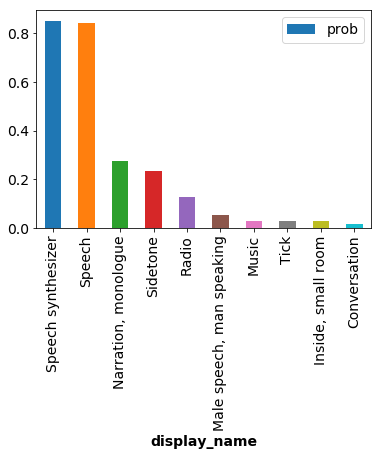

In [47]:
example = pd.DataFrame(class_labels['display_name'][max_prob_classes[i,:10]])
example.loc[:, 'prob'] = pd.Series(max_prob[i, :10], index=example.index)
print(example)
example.plot.bar(x='display_name', y='prob', rot=90)
plt.show()
print()

In [ ]:
#eval_metrics = model.evaluate(x=x_tr, y=y_tr)

In [ ]:
#for i, metric_name in enumerate(model.metrics_names): 
#    print("{}: {:1.4f}".format(metric_name, eval_metrics[i]))

In [27]:
#qtapp = App(model)

from AudioSetClassifier import AudioSetClassifier

import time

ASC = AudioSetClassifier()


Loading VGGish base model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 96, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)

In [28]:
sound_clip = os.path.join(short_raw_dir, video_ids[1]) + '.wav'



t0 = time.time()
test_pred = ASC.predict(sound_clip=sound_clip)
t1 = time.time()

print('Time spent on 1 forward pass prediction:', t1-t0)

Time spent on 1 forward pass prediction: 0.42424607276916504


In [29]:
print(test_pred.shape)

(1, 527)


youtube-dl test video ''_ä↭𝕐

(1, 527)
                  display_name      prob
7           Speech synthesizer  0.850565
0                       Speech  0.842234
5         Narration, monologue  0.276883
518                   Sidetone  0.234527
525                      Radio  0.125816
1    Male speech, man speaking  0.051432
137                      Music  0.029192
407                       Tick  0.028058
506         Inside, small room  0.026996
4                 Conversation  0.017041


/usr/local/anaconda3/envs/audioset_tensorflow/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


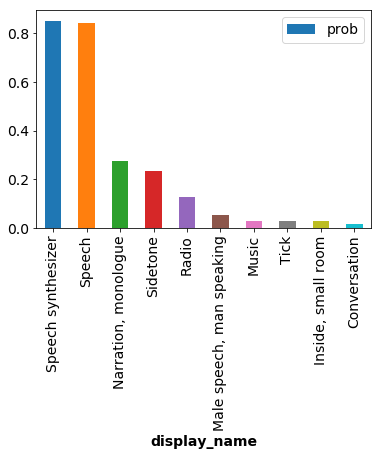


Brandweer - Prio 1 Binnenbrand De Grevelingen Grevelingen Den Bosch - 634TS 651AL

(1, 527)
                        display_name      prob
137                            Music  0.329784
396                            Siren  0.132175
35                 Synthetic singing  0.108727
322                Emergency vehicle  0.108258
0                             Speech  0.079524
398                           Buzzer  0.073568
325  Fire engine, fire truck (siren)  0.045112
318             Air horn, truck horn  0.039988
300                          Vehicle  0.039365
308  Vehicle horn, car horn, honking  0.035074


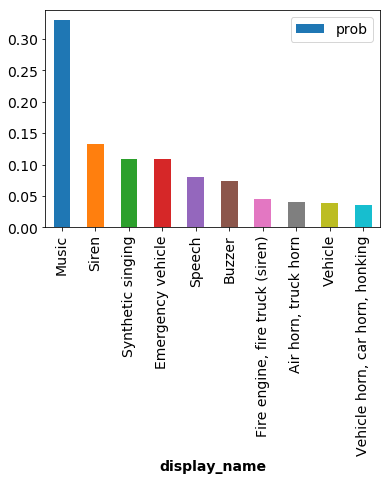


LED Lights + 100W Siren

(1, 527)
                        display_name      prob
322                Emergency vehicle  0.872310
396                            Siren  0.861570
323               Police car (siren)  0.818380
324                Ambulance (siren)  0.654054
325  Fire engine, fire truck (siren)  0.330365
300                          Vehicle  0.197581
310                        Car alarm  0.154480
316                            Truck  0.083475
74                               Dog  0.060292
73            Domestic animals, pets  0.054574


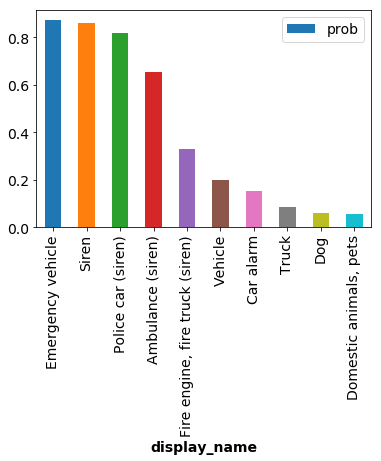


Start

(1, 527)
            display_name      prob
72                Animal  0.184226
435             Eruption  0.143218
426            Explosion  0.115411
87                 Horse  0.100776
137                Music  0.067379
0                 Speech  0.061324
89         Neigh, whinny  0.059073
434           Burst, pop  0.056964
88             Clip-clop  0.045906
301  Boat, Water vehicle  0.039079


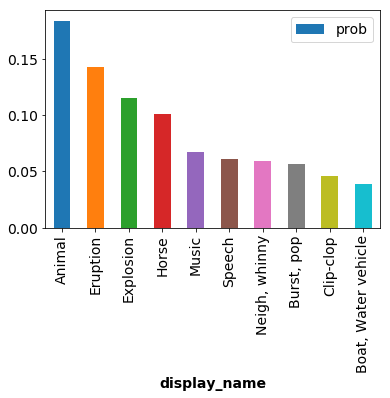


Splitting a Playing Card in ULTRA SLOW MOTION - Smarter Every Day 194

(1, 527)
               display_name      prob
0                    Speech  0.735330
137                   Music  0.507990
442            Chink, clink  0.307995
470                Breaking  0.169158
443                 Shatter  0.087966
365     Cutlery, silverware  0.078805
438                    Chop  0.062590
364  Dishes, pots, and pans  0.061243
440                   Crack  0.044638
418                   Tools  0.042507


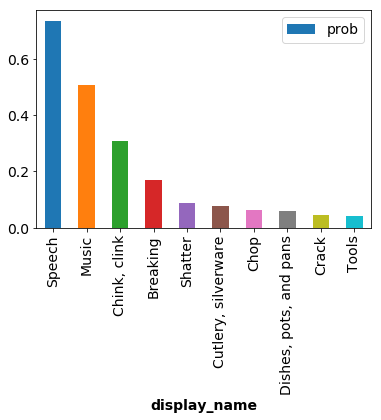


Capuchin Monkeys _ Wild Caribbean _ BBC Earth

(1, 527)
                                display_name      prob
0                                     Speech  0.760512
514                      Environmental noise  0.320111
72                                    Animal  0.241448
112  Bird vocalization, bird call, bird song  0.240419
111                                     Bird  0.210419
113                             Chirp, tweet  0.168693
127                                  Cricket  0.166628
510                Outside, rural or natural  0.102987
126                                   Insect  0.096105
98                                      Fowl  0.080553


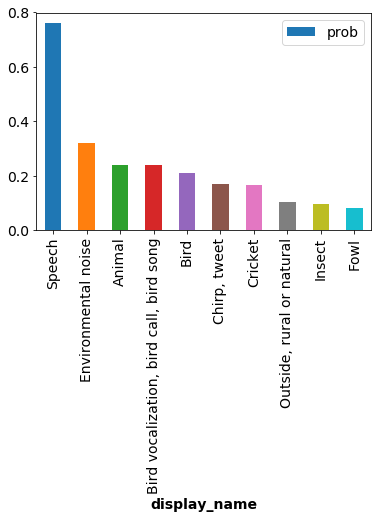


Zoo Animal Sounds!

(1, 527)
                      display_name      prob
0                           Speech  0.675607
300                        Vehicle  0.189700
110                           Roar  0.170084
72                          Animal  0.089746
307                            Car  0.070257
109   Roaring cats (lions, tigers)  0.069534
348  Medium engine (mid frequency)  0.058098
108                   Wild animals  0.056126
135                         Rattle  0.054105
343                         Engine  0.048453


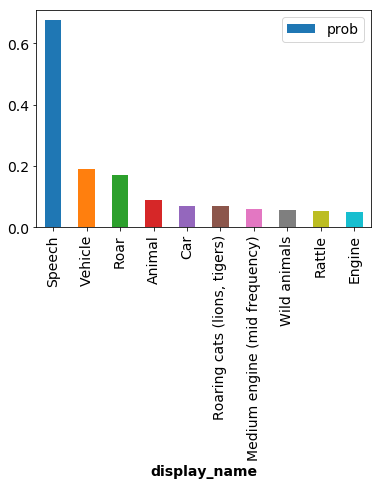

In [30]:
for i, vid in enumerate(video_ids):
    print(video_titles[i])
    print()
    sound_clip = os.path.join(short_raw_dir, vid) + '.wav'
    predictions = ASC.predict(sound_clip=sound_clip)
    max_prob_classes = np.argsort(predictions, axis=-1)[:, ::-1]
    max_prob = np.sort(predictions, axis=-1)[:,::-1]
    
    print(max_prob.shape)
    
    example = pd.DataFrame(class_labels['display_name'][max_prob_classes[0,:10]])
    example.loc[:, 'prob'] = pd.Series(max_prob[0, :10], index=example.index)
    print(example)
    example.plot.bar(x='display_name', y='prob', rot=90)
    plt.show()
    print()

In [ ]:
import sys

app=0           #This is the solution
app = QtGui.QApplication(sys.argv)
MainApp = App(predictor=ASC)
MainApp.show()
sys.exit(app.exec_())

In [ ]:
#from PyQt4 import QtGui, QtCore

class SimpleWindow(QtGui.QWidget):
    def __init__(self, parent=None):
        QtGui.QWidget.__init__(self, parent)

        self.setGeometry(300, 300, 200, 80)
        self.setWindowTitle('Hello World')

        quit = QtGui.QPushButton('Close', self)
        quit.setGeometry(10, 10, 60, 35)

        self.connect(quit, QtCore.SIGNAL('clicked()'),
                     self, QtCore.SLOT('close()'))

if __name__ == '__main__':
    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = QtGui.QApplication([])

    sw = SimpleWindow()
    sw.show()

    try:
        from IPython.lib.guisupport import start_event_loop_qt4
        start_event_loop_qt4(app)
    except ImportError:
        app.exec_()

1. Understand attention
2. Understand filters
3. Understand Multi-label, hierachical, knowledge graphs
4. Understand class imbalance 
5. CCA on VGGish vs. ResNet audioset emb. to check if there's a linear connection. 
6. Train linear layer to convert VGGish emb. to ResNet-50 emb. 

Plot in GUI:
1. Exclude all non-active classes
2. Draw class names on curves going up
3. Remove histogram
4. Make faster

In [ ]:
video_vggish_emb = []
test_wav_path = os.path.join(src_dir, 'data', 'wav_file')
wav_files = os.listdir(test_wav_path)
example_names = []

# Restore VGGish model trained on YouTube8M dataset
# Retrieve PCA-embeddings of bottleneck features
with tf.Graph().as_default(), tf.Session() as sess:
    # Define the model in inference mode, load the checkpoint, and
    # locate input and output tensors.
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, model_checkpoint)
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(
        vggish_params.OUTPUT_TENSOR_NAME)
    # Prepare a postprocessor to munge the model embeddings.
    pproc = vggish_postprocess.Postprocessor(pca_params)
    
    for i, vid in enumerate(wav_files): 
        audio_path = os.path.join(test_wav_path, vid)
        print(vid)

        examples_batch = vggish_input.wavfile_to_examples(audio_path)

        print(examples_batch.shape)

        # Run inference and postprocessing.
        [embedding_batch] = sess.run([embedding_tensor],
                                     feed_dict={features_tensor: examples_batch})
        print(embedding_batch.shape)
        postprocessed_batch = pproc.postprocess(embedding_batch)
        batch_shape = postprocessed_batch.shape
        print(batch_shape)
        
        if batch_shape[0] > 10:
            postprocessed_batch = postprocessed_batch[:10]
        elif batch_shape[0] < 10:
            zero_pad = np.zeros((10, 128))
            zero_pad[:batch_shape[0]] = postprocessed_batch 
            postprocessed_batch = zero_pad
        
        print(postprocessed_batch.shape)
        
        if postprocessed_batch.shape[0] == 10:
            video_vggish_emb.extend([postprocessed_batch])
            example_names.extend([vid])

print(len(video_vggish_emb))

In [ ]:
import audio_event_detection_model as AEDM
import utilities
model = AEDM.CRNN_audio_event_detector()

In [ ]:
(x_user_inp, y_user_inp) = utilities.transform_data(
    np.array(video_vggish_emb)
)
predictions_AEDM = model.predict(
    x=x_user_inp
)


In [ ]:
predictions_ASC = np.zeros([len(wav_files), 527])

for i, vid in enumerate(wav_files): 
    audio_path = os.path.join(test_wav_path, vid)
    predictions_ASC[i] = ASC.predict(sound_clip=audio_path)

In [ ]:
qkong_res = '''2018Q1Q10Q17Q12Q59Q512440Q-5889Q.fea_lab ['Speech'] [0.8013877]
12_4_train ambience.fea_lab ['Vehicle', 'Rail transport', 'Train', 'Railroad car, train wagon'] [0.38702238, 0.6618184, 0.7742054, 0.5886036]
19_3_forest winter.fea_lab ['Animal'] [0.16109303]
2018Q1Q10Q17Q58Q49Q512348Q-5732Q.fea_lab ['Speech'] [0.78335935]
15_1_whistle.fea_lab ['Whistling'] [0.34013063] ['music']
2018Q1Q10Q13Q52Q8Q512440Q-5889Q.fea_lab ['Speech'] [0.7389336]
09_2_my guitar.fea_lab ['Music', 'Musical instrument', 'Plucked string instrument', 'Guitar'] [0.84308875, 0.48860216, 0.43791085, 0.47915566]
2018Q1Q10Q13Q29Q46Q512440Q-5889Q.fea_lab ['Vehicle'] [0.18344605]
05_2_DFA.fea_lab ['Music', 'Musical instrument', 'Plucked string instrument', 'Guitar'] [0.93665695, 0.57123834, 0.53891456, 0.63112855]
'''

q_kong_res = {
    '2018Q1Q10Q17Q12Q59Q512440Q-5889Q.wav': (['Speech'], [0.8013877]),
    '12_4_train ambience.wav': (['Vehicle', 'Rail transport', 'Train', 'Railroad car, train wagon'], [0.38702238, 0.6618184, 0.7742054, 0.5886036]),
    '19_3_forest winter.wav': (['Animal'], [0.16109303]),
    '2018Q1Q10Q17Q58Q49Q512348Q-5732Q.wav': (['Speech'], [0.78335935]),
    '15_1_whistle.wav': (['Whistling'], [0.34013063], ['music']),
    '2018Q1Q10Q13Q52Q8Q512440Q-5889Q.wav': (['Speech'], [0.7389336]),
    '09_2_my guitar.wav': (['Music', 'Musical instrument', 'Plucked string instrument', 'Guitar'], [0.84308875, 0.48860216, 0.43791085, 0.47915566]),
    '2018Q1Q10Q13Q29Q46Q512440Q-5889Q.wav': (['Vehicle'], [0.18344605]),
    '05_2_DFA.wav': (['Music', 'Musical instrument', 'Plucked string instrument', 'Guitar'], [0.93665695, 0.57123834, 0.53891456, 0.63112855])
}


#test_examples_res = qkong_res.split('\n')
#print(test_examples_res)
#rint()
#split_fun = lambda x: x.split(' [')
#test_examples_res = list(map(split_fun, test_examples_res))#

# print(test_examples_res)

In [ ]:
max_prob_classes_AEDM = np.argsort(predictions_AEDM, axis=-1)[:, ::-1]
max_prob_AEDM = np.sort(predictions_AEDM, axis=-1)[:,::-1]

max_prob_classes_ASC = np.argsort(predictions_ASC, axis=-1)[:, ::-1]
max_prob_ASC = np.sort(predictions_ASC, axis=-1)[:,::-1]

for i in range(len(wav_files)):
    print(wav_files[i])
    print(max_prob_classes_AEDM[i,:10])
    print(max_prob_AEDM[i,:10])
    print()
    print(max_prob_classes_ASC[i,:10])
    print(max_prob_ASC[i,:10])
    print()
    print()

2018Q1Q10Q17Q12Q59Q512440Q-5889Q.wav
2018Q1Q10Q13Q52Q8Q512440Q-5889Q.wav
2018Q1Q10Q13Q29Q46Q512440Q-5889Q.wav
2018Q1Q10Q17Q58Q49Q512348Q-5732Q.wav

In [ ]:
for i, vid in enumerate(example_names):
    print(vid)
    print()
    example = pd.DataFrame(class_labels['display_name'][max_prob_classes_AEDM[i,:10]])
    example.loc[:, 'top_10_AEDM_pred'] = pd.Series(max_prob_AEDM[i, :10], index=example.index)
    example.loc[:, 'index_ASC'] = pd.Series(max_prob_classes_ASC[i,:10], index=example.index)
    example.loc[:, 'display_name_ASC'] = pd.Series(
        class_labels['display_name'][max_prob_classes_ASC[i,:10]],
        index=example.index_ASC
    )
    example.loc[:, 'top_10_ASC_pred'] = pd.Series(max_prob_ASC[i, :10], index=example.index)
    print(example)
    example.plot.bar(x='display_name', y=['top_10_AEDM_pred', 'top_10_ASC_pred'] , rot=90)
    plt.show()
    print()
    
    ex_lab = q_kong_res[vid][0]
    ex_pred = q_kong_res[vid][1]
    
    example = pd.DataFrame(class_labels[class_labels['display_name'].isin(ex_lab)])
    example.loc[:, 'AEDM_pred'] = pd.Series(
        predictions_AEDM[i, example.index.tolist()],
        index=example.index
    )
    example.loc[:, 'ASC_pred'] = pd.Series(
        predictions_ASC[i, example.index.tolist()],
        index=example.index
    )
    example.loc[:, 'qkong_pred'] = pd.Series(
        ex_pred,
        index=example.index
    )
    print(example)
    print()
    
    example.plot.bar(x='display_name', y=['AEDM_pred', 'ASC_pred', 'qkong_pred'], rot=90)
    plt.show()

## Audio set data collection pipeline

### Download, cut and convert the audio of listed urls

In [ ]:
colnames = '# YTID, start_seconds, end_seconds, positive_labels'.split(', ')
print(colnames)
bal_train_csv = pd.read_csv('balanced_train_segments.csv', sep=', ', header=2) #usecols=colnames)
bal_train_csv.rename(columns={colnames[0]: colnames[0][-4:]}, inplace=True)

In [ ]:
print(bal_train_csv.columns.values)
print(bal_train_csv.loc[:10, colnames[3]])
print(bal_train_csv.YTID.tolist()[:10])

bal_train_csv['pos_lab_list'] = bal_train_csv.positive_labels.apply(lambda x: x[1:-1].split(','))
colnames.extend('pos_lab_list')

print('Pos_lab_list')
print(bal_train_csv.loc[:10, 'pos_lab_list'])

sample_rate = 16000

audioset_short_raw_dir = os.path.join(src_dir, 'data', 'audioset_short_raw')
if not os.path.exists(audioset_short_raw_dir):
    os.makedirs(audioset_short_raw_dir)
audioset_raw_dir = os.path.join(src_dir, 'data', 'audioset_raw')
if not os.path.exists(audioset_raw_dir):
    os.makedirs(audioset_raw_dir)
audioset_embed_path = os.path.join(src_dir, 'data', 'audioset_embed')
if not os.path.exists(audioset_embed_path):
    os.makedirs(audioset_embed_path)

audioset_video_titles = []
audioset_video_ids = bal_train_csv.YTID.tolist()
audioset_video_ids_bin = bal_train_csv.YTID.astype('|S11').tolist()
video_start_time = bal_train_csv.start_seconds.tolist()
video_end_time = bal_train_csv.end_seconds.tolist()

# Provide class dictionary for conversion from mid to either index [0] or display_name [1] 
class_dict = class_labels.set_index('mid').T.to_dict('list')

print(class_dict['/m/09x0r'])

print(
    list(
        map(
            lambda x: class_dict[x][0],
            bal_train_csv.loc[0, 'pos_lab_list']
        )
    )
)

bal_train_csv['pos_lab_ind_list'] = bal_train_csv.pos_lab_list.apply(
    lambda x: [class_dict[y][0] for y in x]
)

class_vec = np.zeros([1, 527])
class_vec[:, bal_train_csv.loc[0, 'pos_lab_ind_list']] = 1
print(class_vec)

print(bal_train_csv.dtypes)
#print(bal_train_csv.loc[:10, colnames[4]])

In [ ]:
video_ids_incl = []
video_ids_incl_bin = []
video_ids_excl = []
vggish_embeds = []
labels = []

In [ ]:
print(video_ids_incl)

In [ ]:
video_ids_incl = video_ids_incl[:-1]
print(video_ids_incl)
video_ids_checked = video_ids_incl + video_ids_excl
video_ids = [vid for vid in audioset_video_ids if vid not in video_ids_checked]

In [ ]:
for i, vid in enumerate(video_ids):
    print('{}.'.format(i))
    # Download and store video under data/audioset_short_raw/
    if (vid + '.wav') not in os.listdir(audioset_short_raw_dir):
        video_title = dl_yt.download_youtube_wav(
            video_id=vid,
            raw_dir=None,
            short_raw_dir=audioset_short_raw_dir,
            start_sec=video_start_time[i],
            duration=video_end_time[i]-video_start_time[i],
            sample_rate=sample_rate
        )
        audioset_video_titles += [video_title]
        wav_available = video_title is not None
    else:
        print(vid, 'already downloaded, so we skip this download.')
        wav_available = True
    
    if wav_available:
        video_ids_incl += [vid]
        video_ids_incl_bin += [audioset_video_ids_bin[i]]
        vggish_embeds.extend(
            ASC.embed(
                os.path.join(
                    audioset_short_raw_dir,
                    vid
                ) + '.wav'
            )
        )
        class_vec = np.zeros([1, 527])
        class_vec[:, bal_train_csv.loc[i, 'pos_lab_ind_list']] = 1
        labels.extend(class_vec)
    else:
        video_ids_excl += [vid]
    print()
                





In [ ]:
jobs = []
for i, vid in enumerate(video_ids):
    # Download and store video under data/audioset_short_raw/
    if (vid + '.wav') not in os.listdir(audioset_short_raw_dir):
        args = (
            vid,
            None,
            audioset_short_raw_dir,
            video_start_time[i],
            video_end_time[i]-video_start_time[i],
            sample_rate
        )
        process = multiprocessing.Process(
            target=dl_yt.download_youtube_wav,
            args=args
        )
        jobs.append(process)

# Start the processes (i.e. calculate the random number lists)
for j in jobs:
    j.start()

# Ensure all of the processes have finished
for j in jobs:
    j.join()

In [ ]:
save_data(
    hdf5_path=os.path.join(audioset_embed_path, 'bal_train.h5'),
    x=np.array(vggish_embeds),
    video_id_list=np.array(video_ids_incl_bin),
    y=np.array(labels)
)

In [ ]:
x, y, vid_list = load_data(os.path.join(audioset_embed_path, 'bal_train.h5'))

In [ ]:
print(vid_list)

In [ ]:
x_train, y_train, video_id_train = load_data(os.path.join(audioset_embed_path, 'bal_train.h5'))

In [ ]:
print(video_id_train)

In [ ]:
x_train, y_train, video_id_train = load_data(
    os.path.join(
        'data',
        'audioset',
        'packed_features',
        'bal_train.h5'
    )
)

print(video_id_train[:100])

In [2]:
from retrieve_audioset import retrieve_embeddings

retrieve_embeddings(
    data_path=os.path.join('data', 'audioset')
)


Loading VGGish base model:


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 32, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 16, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 16, 256)       295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 16, 256)       590080    
__________

/Users/maxvo/Documents/EDU_demos/audioset/retrieve_audioset.py:101: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  metadata = pd.read_csv(metadata_file, sep=', ', header=2) #usecols=colnames)
  0%|          | 0/22160 [00:00<?, ?it/s]

Done downloading, now converting ...
BGZ Movies  -  Juste Pour Délirer 
	short clip saved in:
		 data/short_raw/--PJHxphWEs.wav


KeyboardInterrupt: 